In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import fidle.pwk as pwk

In [2]:
#On spécifie les dimesions des images d'entrée et du batch
batch_size = 100
img_height = 250
img_width = 250

In [3]:
#Répartition du dataset en train test et validation 
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Accident dataset/train',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'Accident dataset/test',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    'Accident dataset/val',
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

Found 806 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 109 files belonging to 2 classes.


In [4]:
for images, labels in training_ds:
    input_shape = images.shape
    output_shape = labels.shape
    print(f"Input shape: {input_shape}")
    print(f"Output shape: {output_shape}")

Input shape: (100, 250, 250, 3)
Output shape: (100,)
Input shape: (100, 250, 250, 3)
Output shape: (100,)
Input shape: (100, 250, 250, 3)
Output shape: (100,)
Input shape: (100, 250, 250, 3)
Output shape: (100,)
Input shape: (100, 250, 250, 3)
Output shape: (100,)
Input shape: (100, 250, 250, 3)
Output shape: (100,)
Input shape: (100, 250, 250, 3)
Output shape: (100,)
Input shape: (100, 250, 250, 3)
Output shape: (100,)
Input shape: (6, 250, 250, 3)
Output shape: (6,)


In [5]:
print(training_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [6]:
class_names = training_ds.class_names

## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_ds = training_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [20]:
#Définition des couches du modèle
model = tf.keras.Sequential([
    base_model,
    layers.Flatten(input_shape=(250, 250, 3)),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation= 'softmax')
])

In [21]:
#Résumé du modèle
model.summary()
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 81920)             0         
                                                                 
 dense_10 (Dense)            (None, 128)               10485888  
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 2)                 258       
                                                      

In [22]:
#Entraînement du modèle
batch_size  = 64
epochs      =  40
import time
start_time = time.process_time()
print(start_time)
history = model.fit(  training_ds,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = 1,
                      validation_data = validation_ds)
print (time.process_time() - start_time, "seconds")

7513.03125
Epoch 1/40
9/9 [==============================] - 15s 1s/step - loss: 4.3682 - accuracy: 0.5124 - val_loss: 2.2067 - val_accuracy: 0.5321
Epoch 2/40
9/9 [==============================] - 11s 1s/step - loss: 1.9552 - accuracy: 0.5608 - val_loss: 2.4420 - val_accuracy: 0.5229
Epoch 3/40
9/9 [==============================] - 11s 1s/step - loss: 1.0607 - accuracy: 0.6563 - val_loss: 0.5793 - val_accuracy: 0.7615
Epoch 4/40
9/9 [==============================] - 11s 1s/step - loss: 0.4401 - accuracy: 0.8040 - val_loss: 0.7462 - val_accuracy: 0.6606
Epoch 5/40
9/9 [==============================] - 11s 1s/step - loss: 0.3859 - accuracy: 0.8151 - val_loss: 0.4246 - val_accuracy: 0.8073
Epoch 6/40
9/9 [==============================] - 11s 1s/step - loss: 0.2259 - accuracy: 0.9107 - val_loss: 0.3712 - val_accuracy: 0.8165
Epoch 7/40
9/9 [==============================] - 11s 1s/step - loss: 0.1640 - accuracy: 0.9429 - val_loss: 0.2477 - val_accuracy: 0.8991
Epoch 8/40
9/9 [=======

In [23]:
#Evalue l'accuracy et les loss du modèle
score = model.evaluate(testing_ds, verbose=0)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.1910
Test accuracy : 0.9500


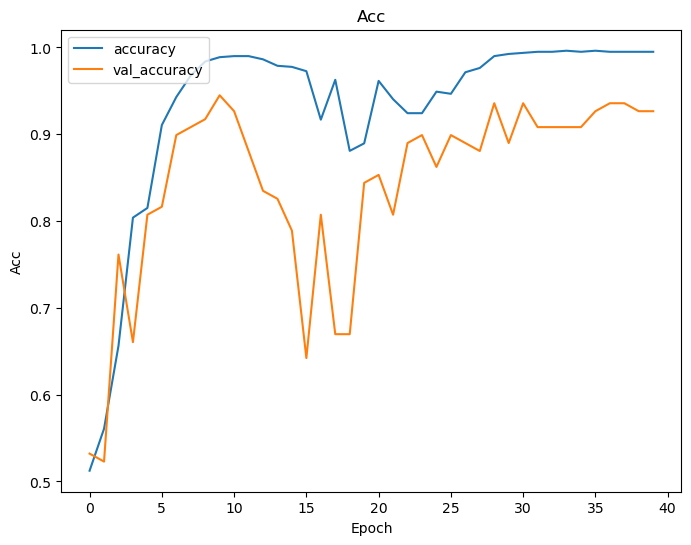

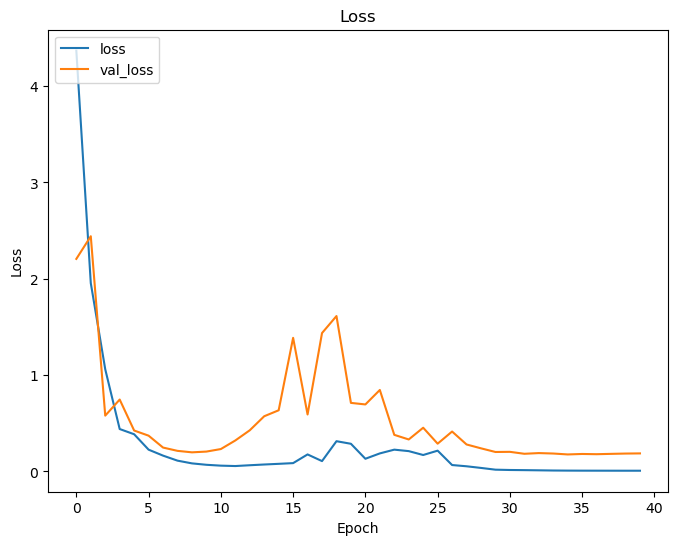

In [24]:
pwk.plot_history(history,  plot={'Acc':['accuracy','val_accuracy'],'Loss':['loss','val_loss']})

4/4 [==============================] - 4s 538ms/step


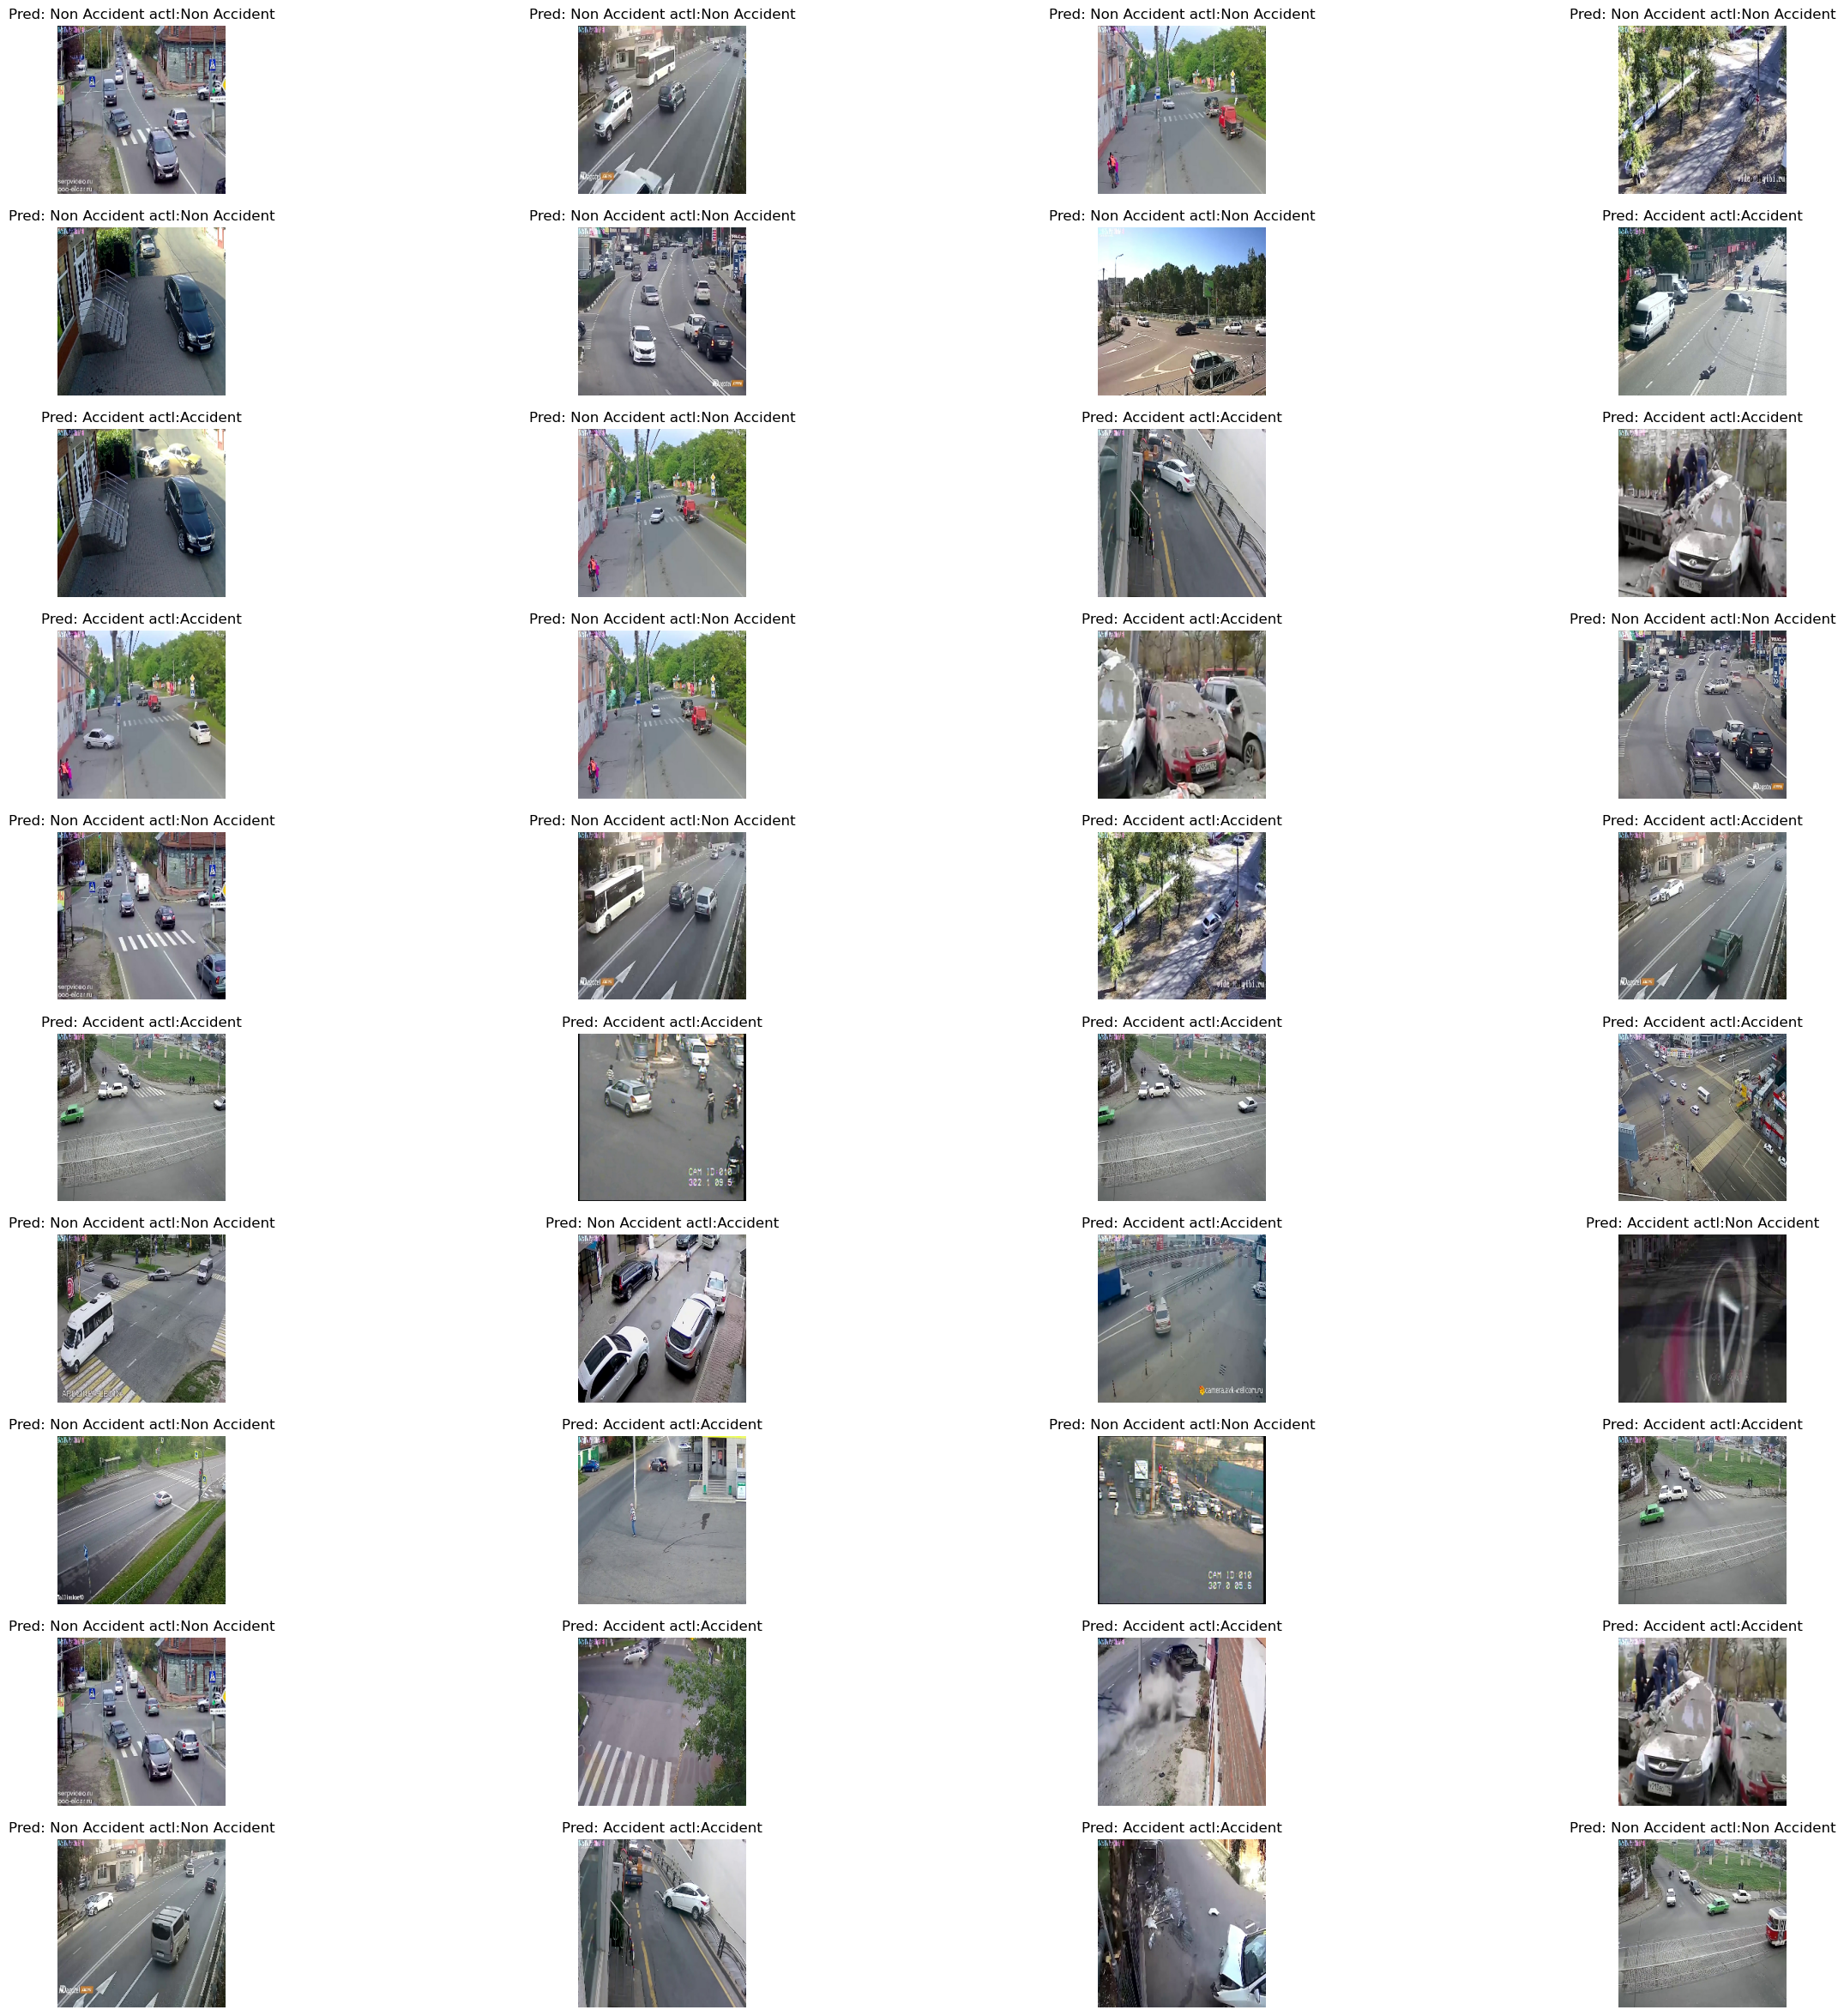

In [25]:
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_ds.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [26]:
score = model.evaluate(validation_ds, verbose=1)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

2/2 [==============================] - 2s 182ms/step - loss: 0.1871 - accuracy: 0.9266
Test loss     : 0.1871
Test accuracy : 0.9266


1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        47
           1       0.96      0.94      0.95        53

    accuracy                           0.95       100
   macro avg       0.95      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

0.95


([<matplotlib.axis.YTick at 0x23b4db20a90>,
 [Text(0, 0, '0'), Text(0, 1, '1')])

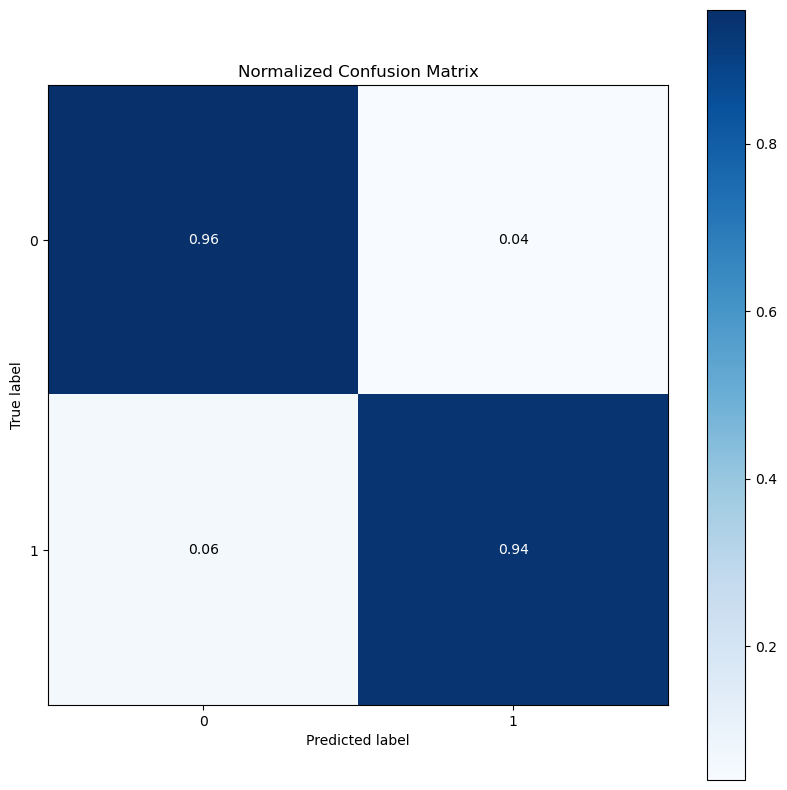

In [27]:
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import scikitplot as skplt 

# Faire des prédictions pour les données de test
predictions = model.predict(testing_ds)

# Extraire les vraies étiquettes de classe pour les données de test
y_test = np.concatenate([labels for images, labels in testing_ds], axis=0)

# Convertir les prédictions en vecteurs de classes binaires
y_pred = np.argmax(predictions, axis=1)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
skplt.metrics.plot_confusion_matrix(y_test,y_pred, normalize=True, figsize=(10,10))
tick_marks = np.arange(2)
plt.xticks(tick_marks, range(2))
plt.yticks(tick_marks, range(2))

In [28]:
# save model to a specified directory for later use
tf.keras.models.save_model(model, "saved model")

INFO:tensorflow:Assets written to: saved model\assets


INFO:tensorflow:Assets written to: saved model\assets
